<a href="https://colab.research.google.com/github/phamtrong2k1/doancuoiki/blob/main/FinalAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#Tải và xuất dữ liệu lên

import os
import cv2
import numpy as np
import pandas as pd

def data_loader():
    
    # Tải tập dữ liệu sinh trắc học
    data_frame = pd.read_csv('/content/drive/MyDrive/AI/Facial_Keypoints/dataset_facial-keypoints-detection/training.csv')
    # Chuyển đổi dữ liệu thành mảng số
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    # Chỉ lấy 15 điểm dữ liệu khuôn mặt
    data_frame = data_frame.dropna()  
   
    # Trích xuất các giá trị pixels của hình ảnh
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    # Chuẩn hóa dữ liệu, lấy các vecto đầu ra là (0,1)
    imgs_array = imgs_array.astype(np.float32) 
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Trích xuất nhãn trong dữ liệu
    labels_array = data_frame[data_frame.columns[:-1]].values
    # Chuẩn hóa dữ liệu, tọa độ đầu ra là là (-1,1)
    labels_array = (labels_array - 48) / 48   
    labels_array = labels_array.astype(np.float32) 
    
    return imgs_array, labels_array


In [ ]:

# Xây dựng hình ảnh, huấn luyện và lưu mô hình CNN

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation, BatchNormalization
from keras.layers import Flatten, Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

# Tạo mô hình

def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Kích thước đầu vào: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))
    
    return model

X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)


In [ ]:

epochs = 100
batch_size = 128

model = the_model()
hist = History()

# Kiểm tra các mô hình, chọn ra mô hình đúng nhất
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/AI/Facial_Keypoints/checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Huấn luyện mô hình
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

# Lưu mô hình
model.save('/content/drive/MyDrive/AI/Facial_Keypoints/model1.h5')



Epoch 1/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0626 - accuracy: 0.4724
Epoch 1: val_loss improved from inf to 0.01375, saving model to /content/drive/MyDrive/AI/Facial_Keypoints/checkpoint1.hdf5
14/14 [==============================] - 1s 53ms/step - loss: 0.0614 - accuracy: 0.4784 - val_loss: 0.0137 - val_accuracy: 0.4322
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0160 - accuracy: 0.5349
Epoch 2: val_loss improved from 0.01375 to 0.01023, saving model to /content/drive/MyDrive/AI/Facial_Keypoints/checkpoint1.hdf5
14/14 [==============================] - 1s 38ms/step - loss: 0.0158 - accuracy: 0.5339 - val_loss: 0.0102 - val_accuracy: 0.4439
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0103 - accuracy: 0.6478
Epoch 3: val_loss improved from 0.01023 to 0.00925, saving model to /content/drive/MyDrive/AI/Facial_Keypoints/checkpoint1.hdf5
14/14 [==============================] - 1s 39ms/step - loss: 0.0103 - accu

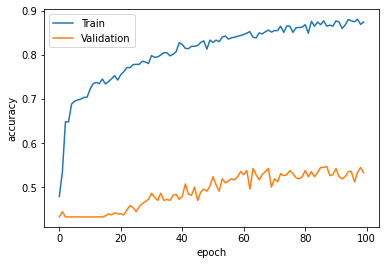

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

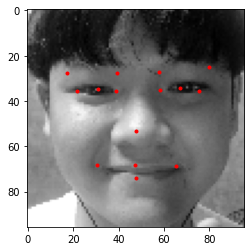

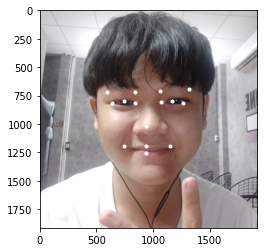

In [ ]:
# Kiểm tra mô hình bằng cách đưa hình vào

import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Tải mô hình đã lưu lên
from keras.models import load_model
model = load_model('/content/drive/MyDrive/AI/Facial_Keypoints/model1.h5')

def detect_points(face_img):
    me = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)
    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48) + 48 

    return label_points
    
# Tải thư viện haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Thêm hình vào để kiểm tra
img = cv2.imread('/content/drive/MyDrive/AI/Facial_Keypoints/predict/trong1.jpg')
new_width = 224
new_height = 224
img_resized = cv2.resize(src=img, dsize=(new_width, new_height))

# Làm xám hình để làm nổi các điểm ảnh, sau đó nhận diện và đưa ra ảnh màu
default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False

all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
    
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=3)
    plt.show()
       
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()


In [ ]:
# Kiểm tra mô hình bằng cách đưa video vào


from keras.models import load_model
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time


# Tải mô hình huấn luyện
model = load_model('/content/drive/MyDrive/AI/Facial_Keypoints/model1.h5')


# Đưa đường dẫn video
input_file = '/content/drive/MyDrive/AI/Facial_Keypoints/predict/Marvel.mp4'


# Tên file trả về
output_filename = 'testVideo_out.avi'  


def get_points_main(img):

    def detect_points(face_img):
        me  = np.array(face_img)/255
        x_test = np.expand_dims(me, axis=0)
        x_test = np.expand_dims(x_test, axis=3)

        y_test = model.predict(x_test)
        label_points = (np.squeeze(y_test)*48)+48

        return label_points

    # Tải thư viện haarcascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    dimensions = (96, 96)

    try:
        default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(default_img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)

    except:
        return []

    faces_img = np.copy(gray_img)

    plt.rcParams["axes.grid"] = False

    all_x_cords = []
    all_y_cords = []

    for i, (x,y,w,h) in enumerate(faces):

        h += 10
        w += 10
        x -= 5
        y -= 5

        try:
            just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
        except:
            return []
        cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

        scale_val_x = w/96
        scale_val_y = h/96

        label_point = detect_points(just_face)

        all_x_cords.append((label_point[::2]*scale_val_x)+x)
        all_y_cords.append((label_point[1::2]*scale_val_y)+y)

    final_points_list = []
    try:
        for ii in range(len(all_x_cords)):
            for a_x, a_y in zip(all_x_cords[ii], all_y_cords[ii]):
                final_points_list.append([a_x, a_y])
    except:
        return final_points_list

    return final_points_list

# Tải video lên 
cap = cv2.VideoCapture(input_file)
ret, frame = cap.read()
height, width, channel = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_filename, fourcc, 20.0, (width, height))

frame_no = 0
while (True):

    a = time.time()
    frame_no += 1
    ret, frame = cap.read()
    if frame_no > 75*30:
        break
    if frame_no in range(60*30, 75*30):
        points = get_points_main(frame)

        try:
            overlay = frame.copy()
        except Exception as e:
            print(e)
            break

        for point in points:

            cv2.circle(frame, tuple(point), 3, (255, 255, 255), -1)

        if len(points) != 0:
            o_line_points = [[12,13], [13,11], [11,14], [14,12], [12,10], [11,10], [10,3], 
                             [12,5], [11,3], [10,5], [10,4], [10,2], [5,1], [1,4], [2,0], 
                             [0,3], [5,9], [9,8], [8,4], [2,6], [6,7], [7,3]]
            num_face = len(points)//15

            for i in range(num_face):
                line_points = np.array(o_line_points) + (15*(i))

                the_color = (189, 195, 199)

                for ii in line_points:
                    cv2.line(overlay, tuple(points[ii[0]]), tuple(points[ii[1]]), the_color, thickness=1)

        opacity = 0.3
        cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)
        out.write(frame)
        b = time.time()
        print(str((b-a)))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
           
cap.release()
out.release()
cv2.destroyAllWindows()
print(ret)


0.18343448638916016
0.1866309642791748
0.1872260570526123
0.18788766860961914
0.19508886337280273
0.20121216773986816
0.18550491333007812
0.1861867904663086
0.19820499420166016
0.19728469848632812
0.19002938270568848
0.1870739459991455
0.19321250915527344
0.1158442497253418
0.11969518661499023
0.12122201919555664
0.1314690113067627
0.15633416175842285
0.1339247226715088
0.13006854057312012
0.1262972354888916
0.14133858680725098
0.17720770835876465
0.19571328163146973
0.19461560249328613
0.18812870979309082
0.20570826530456543
0.15261292457580566
0.16932988166809082
0.14666533470153809
0.14113497734069824
0.15813660621643066
0.19058680534362793
0.31551456451416016
0.20212030410766602
0.2000441551208496
0.21077418327331543
0.21130776405334473
0.24090099334716797
0.2899482250213623
0.2580244541168213
0.25971484184265137
0.2716386318206787
0.2658088207244873
0.2568802833557129
0.25194573402404785
0.275310754776001
0.2501487731933594
0.24797821044921875
0.24252605438232422
0.259298086166381